# Gaussian Processes Regression


In this notebook, we will implement a Gaussian Processes Regression model from scratch and apply it to solve practical problems. The main objectives are:

1. Understanding how to fit a Gaussian Process Regression model.
2. Investigating how the kernel hyper-parameters can affect the model fitting.
3. Understanding how to select kernel hyper-parameters via *marginal loglikelihood optimisation*. 


In [1]:
import autograd.numpy as np
from autograd import value_and_grad
import pandas as pd
import scipy
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Toy Data

As a start, we will consider a synthetic dataset consisting of 3 data points of dimension 1, $X = \{x_1, x_2, x_3 \} = \{ -1, 0, 1 \}$, and the response variables $y = \{y_1, y_2, y_3\}$ are generated as follows:
\begin{align*}
  y_i &= f(x_i) = \frac{1}{1 + \exp(- x_i)} - 1 \;.
\end{align*}

In [2]:
def f(x):
  """Data generating process."""
  # return np.pi * x + 0.5
  return 1 / (1 + np.exp(- x)) - 1

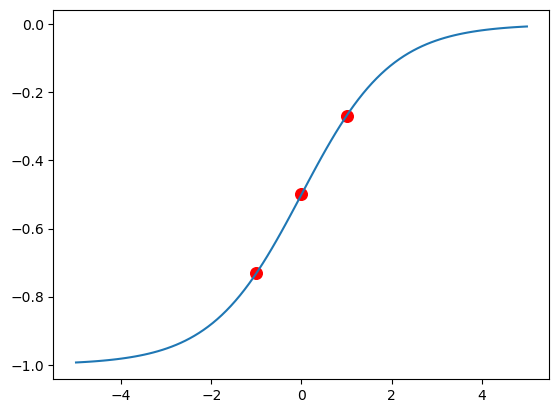

In [3]:
# observed data
toy_X = np.array([-1., 0., 1.])
toy_y = f(toy_X)

# plot observed data
plot_x = np.linspace(-5., 5., 100)
plt.plot(plot_x, f(plot_x))
plt.scatter(toy_X, toy_y, color="red", s=70)

## Specifying a GP Prior

Our aim is to approximate the function $f$ by fitting a Gaussian Process. That is, we place a GP prior on $f$ and seek the posterior distribution of $f$ conditional on the observed data. 

We will use a **noisy observations** model $y_i = f(x_i) + \epsilon_i$, where $\epsilon_i \sim \mathcal{N}(0, \sigma^2)$ are i.i.d. Gaussian noise with variance $\sigma^2$. Recall the GP model with mean function $m$ and kernel (covariance) function $K$ is,
$$
  f(X) \sim \mathcal{N}(m(X), K(X, X)) \;,
$$
where $X = (x_1, \ldots, x_N)$. Choosing a **zero function** for $m$, the posterior distribution at $M$ new test points $X^* = (x_1^*, \ldots, x_M^*)$ is 
\begin{align*}
  f^* | X, \mathbf{y}, X^* 
  &\sim \mathcal{N}( \tilde{m} ,\; \tilde{\Sigma} ) \;, \\
  \tilde{m} &= K(X^*, X) [ K(X, X) + \sigma^2 I_n ]^{-1} \mathbf{y}, \\
  \tilde{\Sigma} &= K(X^*, X^*) - K(X^*, X) [K(X, X) + \sigma^2 I_n]^{-1} K(X, X^*) ) 
    ;.
\end{align*}

Remarks:
1. **Zero prior mean:** The choice of $m \equiv 0$ is without loss of generality because we can always center the response variable by subtracting its empirical mean.
2. **Noisy observation model:** We could in principle use a noise-free observation model for this toy dataset. However, using the noisy model allows us to write the code in more generality, which will be helpful when we work with the real-life dataset in the second part of this notebook. Moreover, we will see later how to select the model hyper-parameters using a data-centric approach (i.e., log marginal likelihood maximisation). If the data are indeed generated from a noiseless process, then we should be able to recover the noise-free setting by selecting a very small $\sigma_2$.

For the **kernel function**, we will use the **Squared Exponential** kernel, also known as the **Radial Basis Function** (RBF) kernel. It is one of the most widely used choice of kernel function. Recall from the lecture notes that it is defined as
$$
k(x, x') = \theta_1^2 \exp\left( - \frac{1}{2 \theta_2^2} \| x - x' \|_2^2 \right) \;,
$$
where $\theta_1, \theta_2 > 0$ are hyper-parameters that we need to specify. As we will see, the choice of these kernel hyper-parameters can have significant impact on the model quality. In practice, they are often chosen in a ''data-centric'' mannor, or by domain knowledge of the problem at hand. 

For now, we will set $\theta_1, \theta_2 = 1$.

Also note that $d = 1$ in this example, so the squared $l_2$ norm reduces to $(x-x')^2$. Throughout this notebook, we will use the $l_2$ norm in order to present everything in full generality, although **for the implementation you can assume the input is always one-dimensional**.

We implement a RBF Kernel with the following, requirements

1. take as its input two rank-1 arrays of potentially different shapes, e.g., $x = [x_1, x_2, x_3] = [1., 2., 3.], y = [y_1, y_2] = [4., 5.]$.
2. output a kernel matrix with appropriate shape, e.g., k(x, y) is a $3 \times 2$ array, where $k(x, y)_{i, j} = k(x_i, y_j)$.


In [4]:
class Kernel:
  def __init__(self):
    pass

  def __call__(self, x, y, theta: list=None):
    raise NotImplementedError()

class RBF(Kernel):
  def __call__(self, x, y, theta: list=None):
    """
    Given an input array x of size n and another input array y of 
    size m, compute the n by m kernel matrix whose (i, j)-th entry 
    is k(x_i, y_j).

    Args:
      x: (n,)
      y: (m,)
    
    Returns:
      k_mat: (n, m)
    """
    # unpack hyper-params
    self.theta1, self.theta2 = theta

    diff = np.expand_dims(x, 1) - np.expand_dims(y, 0)
    k_mat = self.theta1**2 * np.exp( - 1 / (2 * self.theta2**2) * diff**2)

    return k_mat

In [5]:

rbf = RBF()
rbf(np.array([1., 2., 3.]), np.array([1., 2.]), theta=[1., 1.])


array([[1.        , 0.60653066],
       [0.60653066, 1.        ],
       [0.13533528, 0.60653066]])

Expected output:
```python
array([[1.        , 0.60653066],
       [0.60653066, 1.        ],
       [0.13533528, 0.60653066]])
```

## Gaussian Processes Regression

We now implement a GP where the prior mean is assumed to be the **zero function**. The same logic will follow if an arbitrary mean function was used, except that the posterior mean and covariance will take a different form.



we implement a Gaussian Process model with a predict method. we:
1. Compute the posterior mean vector and covariance matrix for a given array of test points `x_star`.
2. Draw posterior samples for the predicted functional values at these test points.
3. Allow `x_star` to be a 1-rank array of arbitrary shape instead of only a scalar.



In [6]:
class GP:
  def __init__(self, kernel: callable):
    """
    Args:
      kernel:
      prior_mean:
    """
    self.k = kernel

  def predict(
      self, 
      x_star, 
      X: np.array=None, 
      y: np.array=None, 
      size: int=1,
      theta: list=None,
      sigma: float=0.,
    ):
    """
    Given observations (X, y) and test points x_star, fit a GP model
    and draw posterior samples for f(x_star) from the fitted model.

    Args:
      x_star: (n*,) array of feature values at which predictions
        for f(x_star) will be made.
      X: (n,) observed features.
      y: (n,) observed response variables.
      size: number of posterior samples drawn.
      theta: (n_hyperparams,) array of kernel hyper-parameters.

    Returns:
      y_star: (size, n*) array of posterior samples for f(y_star).
    """
    k_xs_x = self.k(x_star, X, theta) # m, n
    k_x_xs = np.transpose(k_xs_x) # n, m
    k_xs_xs = self.k(x_star, x_star, theta) # m, m
    k_x_x = self.k(X, X, theta) # n, n
    cov_x_x = k_x_x + sigma**2 * np.eye(len(X))

    # 2. compute posterior means and covariance matrix
    posterior_mean = np.matmul(
        k_xs_x,
        np.linalg.solve(cov_x_x, y), # n,
    )

    posterior_var = (
        k_xs_xs -
        np.matmul(
            k_xs_x,
            np.linalg.solve(cov_x_x, k_x_xs),
        )
    ) # m, m

    # # add jitter for numerical stability
    # posterior_var += 1e-18 * np.eye(posterior_var.shape[0])

    self.posterior_mean = posterior_mean
    self.posterior_var = posterior_var

    # 3. draw posterior samples by using the posterior
    # mean and covariance matrix
    y_star = np.random.multivariate_normal(
        mean=self.posterior_mean,
        cov=self.posterior_var,
        size=size,
    )
    

    return y_star

  def marginal_loglik(self, X, y, theta: list=None, sigma: float=0.):
    """
    Given observations (X, y), compute the marginal loglikelihood
    of a GP model.

    Args:
      X: (n,) observed features.
      y: (n,) observed response variables.
      theta: (n_hyperparams,) array of kernel hyper-parameters.

    Returns:
      log_lik: marginal loglikelihood at (X, y).
    """
    k_x_x = self.k(X, X, theta) # n, n
    cov_x_x = k_x_x + sigma**2 * np.eye(len(X)) # n, n

    data_fit = -0.5 * np.matmul(
        y,
        np.linalg.solve(cov_x_x, y), # n,
    )
    _, log_det = np.linalg.slogdet(cov_x_x)
    penalty = - 0.5 * log_det

    log_lik = data_fit + penalty


    return log_lik

 We now fit a GP model on our observations. For the hyper-parameters $\theta = (\theta_1, \theta_2)$ of the RBF kernel, we choose arbitrarily $\theta_1 = \theta_2 = 1$. We will discuss the effect of different values on the fitted result in the next section.


We then fit a GP model on the observed data and draw 100 posterior samples from the fitted model.
1. Initialise the test points to be 50 equally spaced between -5 and 5.
2. Set the kernel hyper-parameter to be $\theta = (1, 1)$. 
3. Set the noise std to be $\sigma = 0$.

In [7]:
# instantiate kernel and GP model
rbf = RBF()
gp = GP(kernel=rbf)


# initialise test points
toy_xp = np.linspace(-5., 5., 51)

# choose kernel hyper-params
theta = [1., 1.]
sigma = 0.



In [8]:
# draw 100 posterior predictions
# set seed for reproducibility
np.random.seed(1)
yp = gp.predict(x_star=toy_xp, X=toy_X, y=toy_y, size=100, theta=theta, sigma=0.)


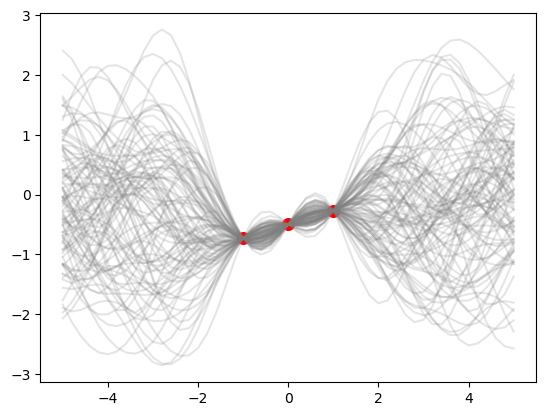

In [9]:
# plot posterior draws and observations
fig = plt.figure()
plt.plot(toy_xp, np.transpose(yp), color="grey", alpha=0.2)
plt.scatter(toy_X, toy_y, color="red", s=70)

## Effect of Kernel Hyper-Parameters

The choice of the kernel hyper-parameters can often have significant consequences on the fitted GP. To illustrate this with the RBF kernel, we choose $\theta_2 = 1$ and vary $\theta_1$, and plot posterior samples drawn from the GP fitted with these hyper-parameters. 

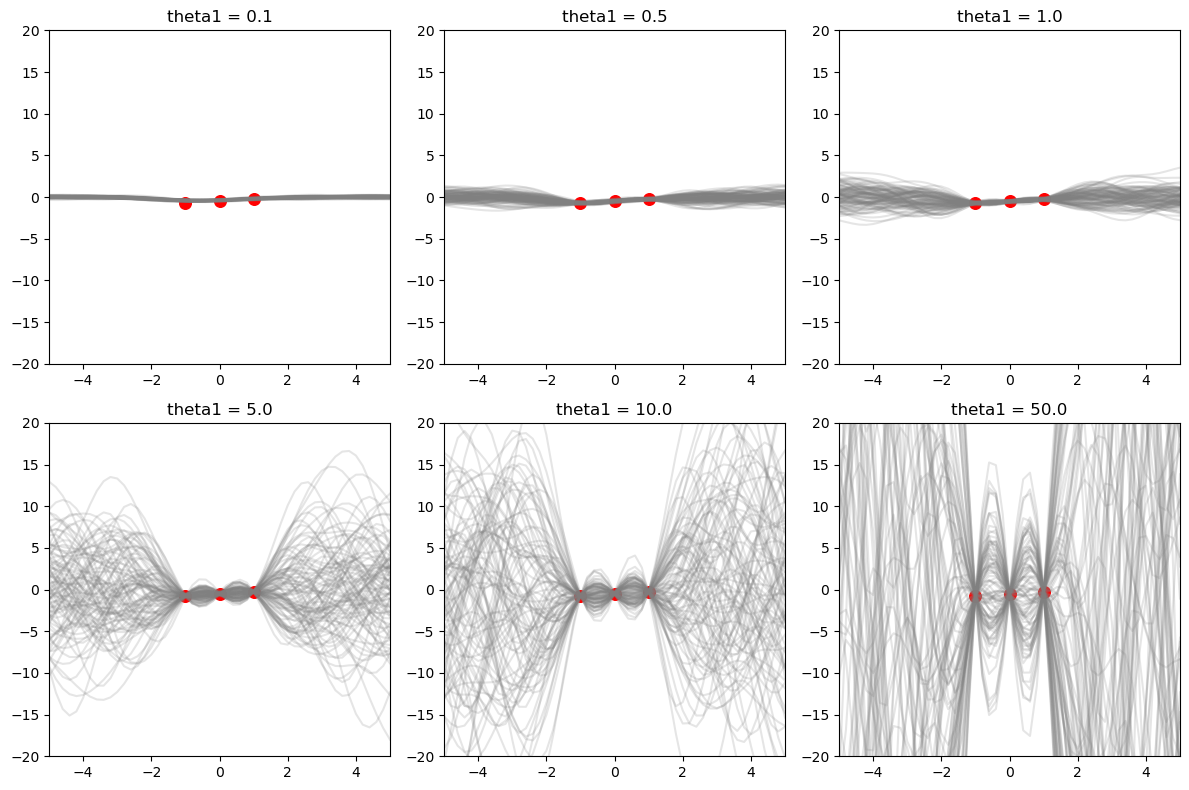

In [10]:
def plot_varying_theta1(theta1_list, theta2=1.):
  """
  Plot posterior draws from GPs fitted with different theta1 and
  fixed theta2.
  """
  nrow = 2
  ncol = 3
  figs, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(12, 8))

  for i, theta1 in enumerate(theta1_list):
    rbf = RBF()
    gp = GP(kernel=rbf)
    yp = gp.predict(
        x_star=toy_xp, X=toy_X, y=toy_y, size=100, theta=[theta1, 1.], sigma=0.1
    )

    axes[i // ncol][i % ncol].plot(toy_xp, np.transpose(yp), color="grey", alpha=0.2)
    axes[i // ncol][i % ncol].scatter(toy_X, toy_y, color="red", s=70)
    axes[i // ncol][i % ncol].set_xlim(-5., 5.)
    axes[i // ncol][i % ncol].set_ylim(-20., 20.)
    axes[i // ncol][i % ncol].set_title(f"theta1 = {theta1}")

  plt.tight_layout()


# vary theta1, fix theta2
theta1_list = np.array([0.1, 0.5, 1., 5., 10., 50.])
plot_varying_theta1(theta1_list)

we now fix $\theta_1$ and vary $\theta_2$.


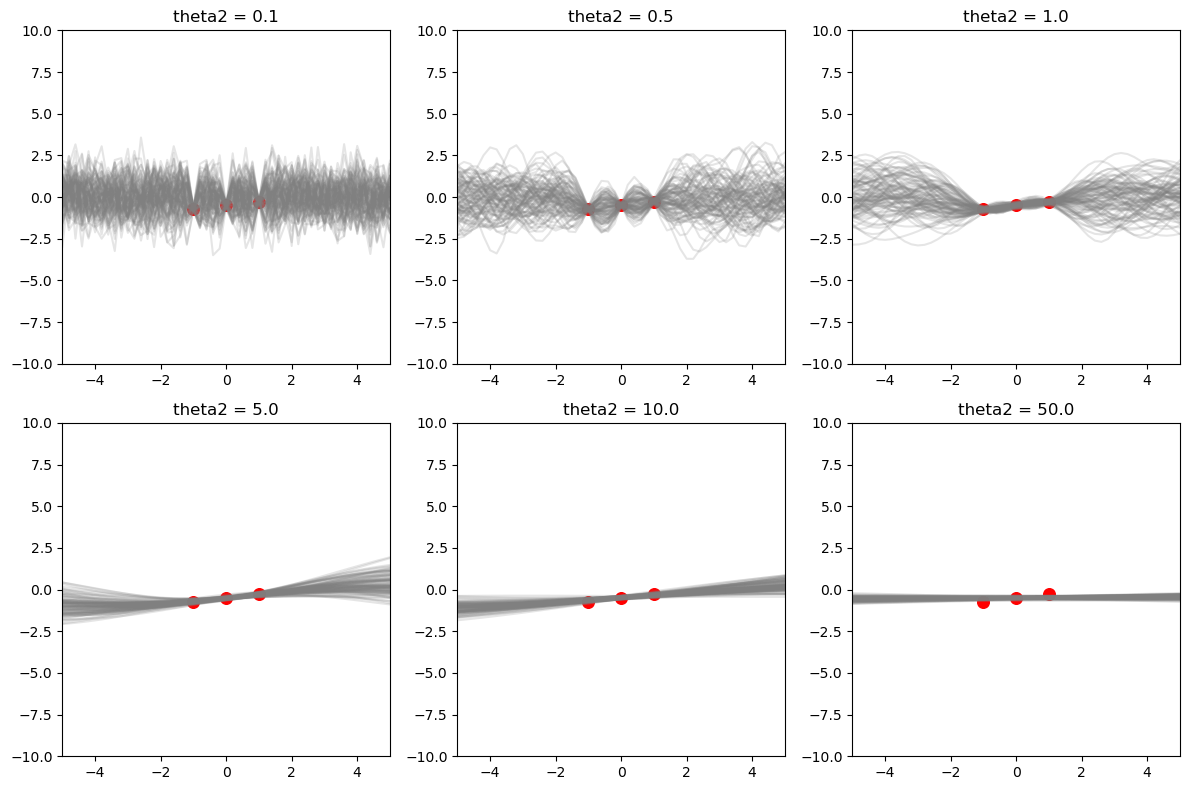

In [11]:
def plot_varying_theta1(theta2_list, theta1=1.):
  """
  Plot posterior draws from GPs fitted with fixed theta1 and
  different theta2.
  """
  nrow = 2
  ncol = 3
  figs, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(12, 8))

  for i, theta2 in enumerate(theta1_list):
    rbf = RBF()
    gp = GP(kernel=rbf)
    yp = gp.predict(
        x_star=toy_xp, X=toy_X, y=toy_y, size=100, theta=[1., theta2], sigma=0.1
    )

    axes[i // ncol][i % ncol].plot(toy_xp, np.transpose(yp), color="grey", alpha=0.2)
    axes[i // ncol][i % ncol].scatter(toy_X, toy_y, color="red", s=70)
    axes[i // ncol][i % ncol].set_xlim(-5., 5.)
    axes[i // ncol][i % ncol].set_ylim(-10., 10.)
    axes[i // ncol][i % ncol].set_title(f"theta2 = {theta2}")

  plt.tight_layout()



# vary theta1, fix theta2
theta2_list = np.array([0.1, 0.5, 1., 5., 10., 50.])
plot_varying_theta1(theta2_list)

## Model Selection
One famous approach to optimise the hyper-parameters in a GP model is by maximising the so-called **marginal likelihood** (also known as **evidence**), $p(y | X)$. It is defined as the following integral of the likelihood multiplied by the prior:
$$
  p(y | X) = \int p(y | f, X) p(f | X) df \;.
$$
The term **marginal** refers to the marginalisation over the functions $f$. Under a GP model, the prior is Gaussian, $f | X \sim \mathcal{N}(0, K)$, so
$$
  \log p(f | X) = -\frac{1}{2} f^\top K(X, X)^{-1} f - \frac{1}{2} \log | K(X, X) | - \frac{n}{2} \log2 \pi \;.
$$
Under the noisy observation assumption, $y_i = f(x_i) + \epsilon$ where $\epsilon \sim \mathcal{N}(0, \sigma^2)$, so the likelihood is a factorised Gaussian $y | f, X \sim \mathcal{N}(f(X), \sigma^2 I_n)$. 

Using the fact that the product of Gaussians is still a Gaussian (e.g., Section 4.2.3 of the lecture notes), we conclude (**exercise**):
\begin{align*}
  \log p(y | X) = - \frac{1}{2} y^\top (K(X, X) + \sigma^2 I_n)^{-1} y - \frac{1}{2} \log | K(X, X) + \sigma^2 I_n | - \frac{n}{2} \log 2\pi \;.
\end{align*}
We call the above equation the **log marginal likelihood**. 
<!-- To emphasize its dependence on the hyper-parameters $\theta$ and $\sigma$, we also write $\log p(y | X, \theta, \sigma)$.  -->

The three terms here have intuitive roles:
- $- \frac{1}{2} y^\top (K(X, X) + \sigma^2 I_n)^{-1} y$ is the **data fit** and is the only term involving the observed targets $y$.
- $\log | K(X, X) + \sigma^2 I_n |$ is the **complexity penalty** that depends only on the input $X$ and kernel fuction.
- $\frac{n}{2} \log 2\pi$ is a **normalising constant** that does not depend on the hyper-parameters $\theta$ nor $\sigma$, so it can be ignored when performing optimisation. 



we implement the log marginal likelihood by completing the marginal_loglik method in the GP class defined in the previous section.


In [12]:
rbf = RBF()
gp = GP(kernel=rbf)

In [13]:

gp.marginal_loglik(X=toy_X, y=toy_y, theta=theta, sigma=sigma)


0.24777372845292323

Expected output:
```python
0.2189792097792156

```

To find the best hyper-parameters, we seek the **partial derivatives** of the marginal loglikelihood with respect to $\theta$ and $\sigma$, i.e., $\frac{\partial}{\partial \theta_j} \log p(y | X) $ and $\frac{\partial}{\partial \sigma} \log p(y | X) $. This can be done by either manually computing these derivatives, or using **auto-differentiation**.

we will use [**auto-differentiation**](https://en.wikipedia.org/wiki/Automatic_differentiation) and an optimisation algorithm called [**conjugate gradient (CG)** method](https://en.wikipedia.org/wiki/Conjugate_gradient_method) to perform the hyper-parameter search. 


In [14]:
def optim_hyperparams(init_params, data_X, data_y, gp, method="CG", maxiter=60):
  """
  Find the best kernel hyper-parameters that maximise the log marginal
  likelihood.
  """
  # define negative log marginal likelihood as objective
  # input is unpacked to theta and sigma
  objective = lambda params: -gp.marginal_loglik(
    data_X, data_y, theta=params[:-1], sigma=params[-1],
  )

  optim_res = minimize(
      fun=value_and_grad(objective),
      jac=True,
      x0=init_params, 
      method=method,
      options={"return_all": True, "maxiter": maxiter},
  )
  return optim_res

We set the initial set of values for the optimiser to be $\theta^{(0)} = (1, 1)$ and $\sigma^{(0)} = 0.1$. Note that the CG method (and in general most optimisation algorithms) can be very sensitive to the starting point.

In [15]:
init_params = [1., 1., 0.1]
otpim_res = optim_hyperparams(init_params=init_params, data_X=toy_X, data_y=toy_y, gp=gp)
otpim_res

 allvecs: [array([1. , 1. , 0.1]), array([ 0.42313487,  1.35047193, -0.03698245]), array([0.39694737, 1.43099154, 0.00952439]), array([0.5329421 , 1.72323416, 0.05743319]), array([ 0.61418008,  2.01474971, -0.00361021]), array([ 0.4747777 ,  2.27710604, -0.00325649]), array([0.47689261, 2.29410497, 0.006073  ]), array([0.5379288 , 2.57014472, 0.0242008 ]), array([ 0.65519775,  3.12465812, -0.00828072]), array([0.83437408, 4.0738054 , 0.00637173]), array([ 9.44021466e-01,  4.67714465e+00, -3.51233315e-03]), array([1.42375196e+00, 7.39210544e+00, 2.45562860e-03]), array([ 1.57463294e+00,  8.24905990e+00, -1.26123898e-03]), array([ 2.07069848e+00,  1.10750139e+01, -2.34523678e-03]), array([2.41410453e+00, 1.30318485e+01, 1.80908629e-04]), array([ 3.15136622e+00,  1.72410357e+01, -7.11664644e-04]), array([ 5.23559986e+00,  2.91406953e+01, -9.03068935e-04]), array([8.08095521e+00, 4.53859061e+01, 6.07046117e-05]), array([ 1.30577329e+01,  7.38003610e+01, -7.41696343e-05]), array([1.44365322

In [16]:
def show_optim_history(params_history, gp, X, y):
  """
  Plotting util for log marginal likelihood against iterations.
  """
  log_lik_history = []
  for params in params_history:
    log_lik = gp.marginal_loglik(X=X, y=y, theta=params[:-1], sigma=params[-1])
    log_lik_history.append(log_lik)

  plt.plot(log_lik_history)
  plt.xlabel("Iteraitons")
  plt.ylabel("Log marginal likelihood")
  plt.show()
  return log_lik_history

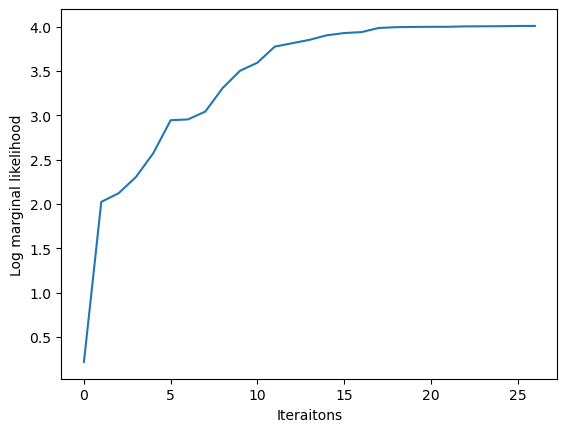

In [17]:
_ = show_optim_history(otpim_res.allvecs, gp, toy_X, toy_y)

# Mauna Loa Atmospheric $\textrm{CO}_2$ Data

we then apply our GP model to a real-life dataset concerning the concentration of $\textrm{CO}_2$. The [Mauna Loa Atmospheric $\textrm{CO}_2$ dataset](https://gml.noaa.gov/ccgg/trends/) consists of concentration of $\textrm{CO}_2$  (in parts per million by volume (ppm)) from the Mauna Loa Observatory from 1958 to 2022. We are interesting in modelling this concentration against time and extrapolating it to future years.

The input $x$ is the observation time (`decimal date`) and the observed target $y$ is the monthly average concentration level (`average`). We aim to fit a **noisy** GP regression model, as we expect the targets are corrupted by noises, potentially due to, e.g., observational error or measurement inaccuracies.

<!-- Note that since this is a time-series data, we expect the observed targets to be **correlated** given test inputs. This renders  -->

## Loading Data

In [18]:
# download data
url = "https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.csv"
df = pd.read_csv(url, skiprows=56) # skip the first 56 rows containing comments
df.head()

,year,month,decimal date,average,deseasonalized,ndays,sdev,unc
0,1958,3,1958.2027,315.70,314.43,-1,-9.99,-0.99
1,1958,4,1958.2877,317.45,315.16,-1,-9.99,-0.99
2,1958,5,1958.3699,317.51,314.71,-1,-9.99,-0.99
3,1958,6,1958.4548,317.24,315.14,-1,-9.99,-0.99
4,1958,7,1958.5370,315.86,315.18,-1,-9.99,-0.99


<AxesSubplot: xlabel='decimal date'>

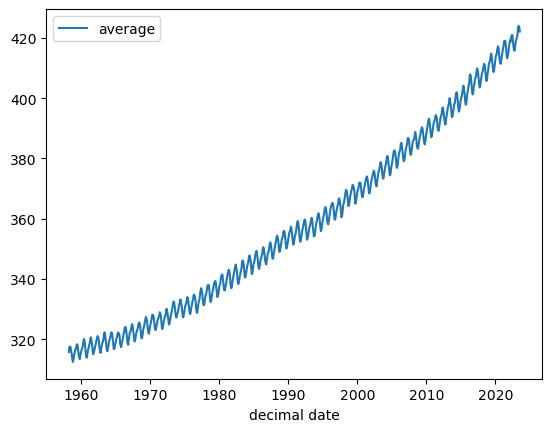

In [19]:
df.plot(x="decimal date", y="average")

<!-- #### Exercise -->

We center the observed target by subtracting its empirical mean. 

In [20]:
# convert data to numpy array
data_X = df["decimal date"].to_numpy()
data_y = df["average"].to_numpy()

# substract empirical mean
data_y -= np.mean(data_y)

## Specifying Kernel Function
We choose as the kernel function a sum of 4 kernel functions that are able to capture different characteristics of the data (recall that sums and products of kernel functions are also kernel functions). Note that we are not claiming this is the best kernel function -- it is entirely possible that other choices are more appropriate for this problem.

1. To model the long-term smooth trend, we use a RBF kernel 
$$
k_1(x, x') = \theta_1^2 \exp\left( - \frac{\| x - x' \|_2^2}{2\theta_2^2} \right) \;.
$$

2. To model the periodic behaviour, we use a product of a RBF kernel and a **periodic kernel**, taking the form
$$
k_2(x, x') = \theta_3^2 \exp\left( - \frac{\| x - x' \|_2^2}{2 \theta_4^2} - \frac{2 \sin^2( \pi (x - x') )}{\theta_5^2} \right) \;,
$$
where $\theta_3$ represents the magnitude, $\theta_4$ is the **decay-time** for the periodic component, and $\theta_5$ gives its smoothness. The period (in the argument of $\sin$) has been set to one (year). This is because the seasonal effect is believed to be caused primarily by the different $\textrm{CO}_2$ level uptake for plants depending on the season, although in principle we could have introduced another hyper-parameter to model it completely from the data. 

3. To model the small/medium-term irregularities, we use a **rational quadratic kernel**
$$
k_3(x, x') = \theta_6^2 \left( 1 + \frac{\| x - x' \|_2^2}{2 \theta_7^2 \theta_8} \right)^{- \theta_8} \;,
$$
where $\theta_6$ gives the magnitude, $\theta_7$ the standard length-scale, and $\theta_8$ the shape parameter. One could have used a RBF kernel for this component. However, since we are interested in modelling the **small/medium** effect, a rational quadratic kernel is a better choice. This is because this kernel decays **polynomially** as a function of $\| x - x'\|_2^2$ (controlled by $\theta_8$), whereas the decay in RBF is exponentially and therefore much faster. This means a rational quadratic kernel can accommodate several length-scales better than a RBF can do.

4. To model the noise term, we use a sum of correlated and uncorrelated components
$$
k_4(x_p, x_q) = \theta_9^2 \exp\left( - \frac{\| x_p - x_q \|_2^2}{2\theta_{10}^2} \right) + \theta_{11}^2 \delta_{pq} \;,
$$
where $\theta_9$ is the magnitude of the correlated component, $\theta_{10}$ the length-scale, and $\theta_{11}$ the magnitude of the uncorrelated component. The correlated term is introduced because the data is a time-series that is believed to suffer from systematic noises (measurement inaccuracies, short-term weather phenomenon etc.). The uncorrelated term serves **exactly the same role as the noise term $\sigma^2 \delta_{pq}$ in a noisy GP model** except a renaming. Therefore, when instantiating $k_4$ in our code we could equivalently only create a RBF kernel with parameters $\theta_9$ and $\theta_{10}$, and **use $\theta_{11}$ as an argument for `sigma` in `gp.predict`**.

One may also wonder whether the first component in $k_4$ is redundant as it has an identical form as $k_1$. The answer is no -- we will see that after hyper-parameter optimisation one will have a **short length-scale (noise)** and the other a **long length-scale (the long-term signal)**. These two terms are, however, **unidentifiable**, meaning that we may observe $k_1$ to have a long length-scale and the first term in $k_4$ to have a short length-scale, and vice versa. It is only a matter of interpretation that we have chosen to call one the "noise" term and the other the "signal".

These choices are made based on our prior understanding of the data (e.g., by inspecting the data plot). This is often how the kernel function for GPs are consructed in practice, where the practitioner choose a combination of kernels that can model different characteristics of the data. For example, the periodic kernel is used if the data exhibit periodic trend, and the RBF kernel is often the go-to choice to model smooth functions. 



we implement the Periodic kernel and the Rational Quadratic kernel.

In [21]:
class Periodic(Kernel):
  def __call__(self, x, y, theta: list=None):
    """
    Compute the periodic kernel matrix.

    Args:
      x: (n,)
      y: (m,)
    
    Returns:
      k_mat: (n, m)
    """
    theta3, theta4, theta5 = theta

    diff = np.expand_dims(x, 1) - np.expand_dims(y, 0)
    k_mat = theta3**2 * np.exp(
        - 1 / (2 * theta4**2) * diff**2 -
        2 * np.sin(np.pi * diff)**2 / theta5**2
    )

    return k_mat

In [22]:
class RationalQuadratic(Kernel):
  def __call__(self, x, y, theta: list=None):
    """
    Compute the rational quadratic kernel matrix.

    Args:
      x: (n,)
      y: (m,)
    
    Returns:
      k_mat: (n, m)
    """
    # unpack hyper-params
    theta6, theta7, theta8 = theta

    diff = np.expand_dims(x, 1) - np.expand_dims(y, 0)
    k_mat = theta6**2 * (
        1 + diff**2 / (2 * theta7**2 * theta8)
    )**(-theta8)
    return k_mat

In [23]:
class Sum(Kernel):
  def __init__(self):
    super().__init__()
    self.rbf = RBF()
    self.periodic = Periodic()
    self.rq = RationalQuadratic()

  def __call__(self, x, y, theta: list=None):
    """
    Compute the kernel matrix k = k_1 + k_2 + k_3 + k_4.

    Args:
      x: (n,)
      y: (m,)
      theta: \theta_1, ..., \theta_{10}
    
    Returns:
      k_mat: (n, m)
    """
    assert len(theta) == 10, \
      "The argument `theta` must contain 10 values \\theta_1, ..., \\theta_{10}. \\theta_{11} should be given to `sigma` instead!"
    
    # REMARK: the uncorrelated term in k_4 is not included here, 
    # as it is handeled separately through the `sigma` argument in 
    # gp.predict(). We can do so because, implementation-wise,
    # sigma and \theta_{11} serve exactly the save purpose.
    # See also the comment below the definition of k_4.
    k_mat = (
        self.rbf(x, y, theta[:2]) +
        self.periodic(x, y, theta[2:5]) +
        self.rq(x, y, theta[5:8]) +
        self.rbf(x, y, theta[8:]) 
    )
    return k_mat

## Fitting the Model

Let us fit a GP regression model with a set of arbitrarily chosen kernel hyper-parameters.

In [24]:
sum_kernel = Sum()
gp = GP(kernel=sum_kernel)


we generate 100 posterior predictions for the concentration level for the future 20 years by:
1. Initialise test time `pred_X` to be an array from the last time point in `data_X` until year 2043 (including both end points), equally spaced with step 1/12. 
2. Set all hyper-parameter values to be $1$.



In [25]:

# predict 20 years into the future
pred_X = np.arange(data_X.max() + 1/12., 2043., step=1/12.)
thetas = np.ones(11)
pred_y = gp.predict(pred_X, data_X, data_y, size=100, theta=thetas[:10], sigma=thetas[10:])


In [26]:
def plot_predicted_co2(data_X, data_y, pred_X, pred_y):
  """
  Plotting util for CO2 predictions.
  """
  fig = plt.figure()
  _ = plt.plot(data_X, data_y, label="observed")
  _ = plt.plot(pred_X, np.transpose(pred_y), label="predicted", color="cyan", alpha=0.2)
  _ = plt.xlabel("Year")
  _ = plt.ylabel("Predicted concentration (centred)")

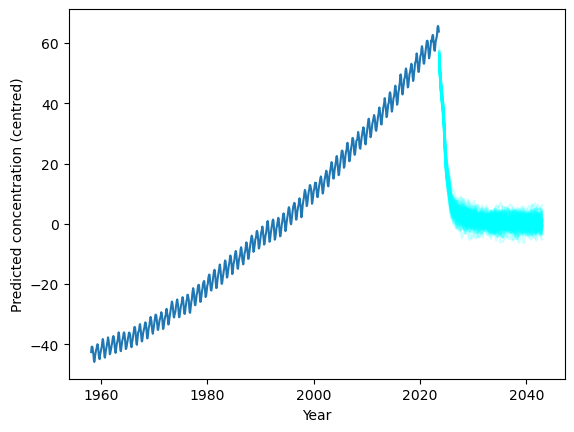

In [27]:
# posterior predictions
_ = plot_predicted_co2(data_X, data_y, pred_X, pred_y)

Let us now optimise the kernel hyper-parameters to improve the model fitting.

The final hyper-parameter values above are only a local optima, since the objective function is highly likely to be multi-modal (it is defined on a 11-dimensional space!). One way to accommodate this is to try multiple starting points for the optimisation algorithm, and select the one that gives the highest log marginal likelihood.

We use 10 sets of initial values, and find the best hyper-parameters in the 10 runs. 

In [28]:
def optim_hyperparams_multiple_runs(init_params_list, data_X, data_y, gp, maxiter=60):
  """
  Run hyper-parameter search with multiple starting points.
  """
  optim_res_list = []
  log_lik_history_list = []
  nrep = len(init_params_list)

  for i in range(nrep):
    print(f"iter {i+1} / {nrep}")
    init_params = init_params_list[i]

    # find best params
    optim_res = optim_hyperparams(
        init_params, data_X, data_y, gp, method="CG", maxiter=maxiter,
    )
    # log_lik_history = show_optim_history(optim_res.allvecs, gp, data_X, data_y)
    params = optim_res.allvecs[-1]
    # compute log marginal lkhd
    log_lik = gp.marginal_loglik(data_X, data_y, theta=params[:-1], sigma=params[-1])

    # store results
    optim_res_list.append(optim_res)
    log_lik_history_list.append(log_lik)

  return optim_res_list, log_lik_history_list 

In [29]:
# 1. Run this for randomly initialised starting points. This can take ~30 mins!
# np.random.seed(2022)
# init_params_list = np.random.uniform(1., 50., (10, 11))
# optim_res_list, log_lik_history_list  = optim_hyperparams_multiple_runs(
#     init_params_list, data_X, data_y, gp
# )

In [30]:
# 2. Run this for starting points generated close to a set of optimal values.
np.random.seed(2022)

# starting values are normally distributed around the optimal values
normal_noise = np.random.normal(size=(10, 11)) * np.array(
    [1., 1., 0.5, 1., 0.5, 0.1, 0.5, 0.1, 0.1, 0.5, 0.1],
)
init_params_list = np.array(
    [66., 67., 2.4, 90., 1.3, 0.66, 1.2, 0.78, 0.18, 1.6, 0.19],
) + normal_noise

# Note: there might be warning messages generated by the optimiser
optim_res_list, log_lik_history_list  = optim_hyperparams_multiple_runs(
    init_params_list, data_X, data_y, gp, maxiter=5
)

iter 1 / 10


c:\Users\44746\anaconda3\envs\mml\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in power
  return f_raw(*args, **kwargs)
c:\Users\44746\anaconda3\envs\mml\lib\site-packages\numpy\linalg\linalg.py:2094: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
c:\Users\44746\anaconda3\envs\mml\lib\site-packages\autograd\numpy\numpy_vjps.py:59: RuntimeWarning: invalid value encountered in power
  lambda ans, x, y : unbroadcast_f(x, lambda g: g * y * x ** anp.where(y, y - 1, 1.)),
c:\Users\44746\anaconda3\envs\mml\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
c:\Users\44746\anaconda3\envs\mml\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in power
  return f_raw(*args, **kwargs)
c:\Users\44746\anaconda3\envs\mml\lib\site-packages\numpy\linalg\linalg.py:2094: RuntimeWarning: invalid val

iter 2 / 10
iter 3 / 10


c:\Users\44746\anaconda3\envs\mml\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in power
  return f_raw(*args, **kwargs)
c:\Users\44746\anaconda3\envs\mml\lib\site-packages\numpy\linalg\linalg.py:2094: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
c:\Users\44746\anaconda3\envs\mml\lib\site-packages\autograd\numpy\numpy_vjps.py:59: RuntimeWarning: invalid value encountered in power
  lambda ans, x, y : unbroadcast_f(x, lambda g: g * y * x ** anp.where(y, y - 1, 1.)),
c:\Users\44746\anaconda3\envs\mml\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
c:\Users\44746\anaconda3\envs\mml\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in power
  return f_raw(*args, **kwargs)
c:\Users\44746\anaconda3\envs\mml\lib\site-packages\numpy\linalg\linalg.py:2094: RuntimeWarning: invalid val

iter 4 / 10


c:\Users\44746\anaconda3\envs\mml\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in power
  return f_raw(*args, **kwargs)
c:\Users\44746\anaconda3\envs\mml\lib\site-packages\numpy\linalg\linalg.py:2094: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
c:\Users\44746\anaconda3\envs\mml\lib\site-packages\autograd\numpy\numpy_vjps.py:59: RuntimeWarning: invalid value encountered in power
  lambda ans, x, y : unbroadcast_f(x, lambda g: g * y * x ** anp.where(y, y - 1, 1.)),
c:\Users\44746\anaconda3\envs\mml\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
c:\Users\44746\anaconda3\envs\mml\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in power
  return f_raw(*args, **kwargs)
c:\Users\44746\anaconda3\envs\mml\lib\site-packages\numpy\linalg\linalg.py:2094: RuntimeWarning: invalid val

iter 5 / 10
iter 6 / 10


c:\Users\44746\anaconda3\envs\mml\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in power
  return f_raw(*args, **kwargs)
c:\Users\44746\anaconda3\envs\mml\lib\site-packages\numpy\linalg\linalg.py:2094: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
c:\Users\44746\anaconda3\envs\mml\lib\site-packages\autograd\numpy\numpy_vjps.py:59: RuntimeWarning: invalid value encountered in power
  lambda ans, x, y : unbroadcast_f(x, lambda g: g * y * x ** anp.where(y, y - 1, 1.)),
c:\Users\44746\anaconda3\envs\mml\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
c:\Users\44746\anaconda3\envs\mml\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in power
  return f_raw(*args, **kwargs)
c:\Users\44746\anaconda3\envs\mml\lib\site-packages\numpy\linalg\linalg.py:2094: RuntimeWarning: invalid val

iter 7 / 10
iter 8 / 10
iter 9 / 10


c:\Users\44746\anaconda3\envs\mml\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in power
  return f_raw(*args, **kwargs)
c:\Users\44746\anaconda3\envs\mml\lib\site-packages\numpy\linalg\linalg.py:2094: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
c:\Users\44746\anaconda3\envs\mml\lib\site-packages\autograd\numpy\numpy_vjps.py:59: RuntimeWarning: invalid value encountered in power
  lambda ans, x, y : unbroadcast_f(x, lambda g: g * y * x ** anp.where(y, y - 1, 1.)),
c:\Users\44746\anaconda3\envs\mml\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
c:\Users\44746\anaconda3\envs\mml\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: invalid value encountered in power
  return f_raw(*args, **kwargs)
c:\Users\44746\anaconda3\envs\mml\lib\site-packages\numpy\linalg\linalg.py:2094: RuntimeWarning: invalid val

iter 10 / 10


We then look to:
1. Find the index of the largest log marginal likelihood from the list `log_lik_history_list`.
2. Find the final hyper-parameters from the run that gave the largest log marginal likelihood, and assign it to `final_params`. 

In [31]:

best_idx = np.argmax(log_lik_history_list)
best_optim_res = optim_res_list[best_idx]
best_log_lik = log_lik_history_list[best_idx]

final_params = best_optim_res.allvecs[-1]


In [32]:

assert len(final_params) == 11, "Expect length of final_params to be 11"


In [33]:
print("final hyper-params:\n", final_params)
print()
print("best log marginal likelihood:", best_log_lik)

final hyper-params:
 [63.69731931 68.13989343  2.0215865  89.13734229  1.13060461  0.60214783
  0.51247492  0.44193211  0.15938962  1.45812433  0.23024852]

best log marginal likelihood: 484.71979643420707


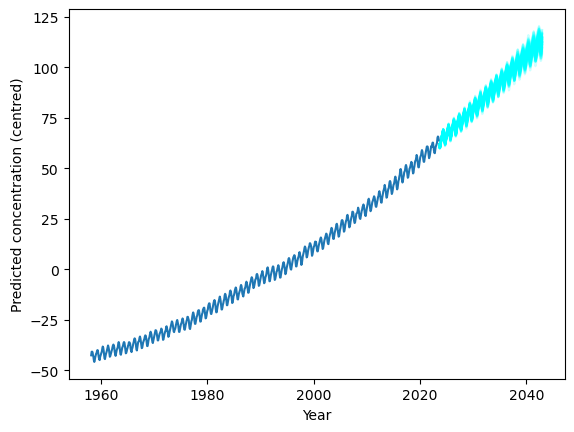

In [34]:
# posterior predictions
pred_y = gp.predict(
    pred_X, data_X, data_y, size=100, theta=final_params[:-1], sigma=final_params[-1],
)

plot_predicted_co2(data_X, data_y, pred_X, pred_y)

## Interpretation of Kernel Hyper-Parameters
Taking the final parameters
```python
final_params = [15.60917401 37.85666397 51.65420898 41.91108205  6.60621616  0.45302811
  0.54545549 21.92928839 27.86849259 20.36595657 -0.25296079]

```
as an example, we see that 
- The long-term trend has magnitude $\theta_1 \approx 16$ and a length-scale of $\theta_2 \approx 38$ years. 
- The periodic contribution has magnitude $\theta_3 \approx 52$, decay-time $\theta_4 \approx 42$ years, and smoothness $\theta_5 \approx 7$. The long decay-time shows that the data has a component that is very close to a seasonal periodicity in the short term.
- The medium/short-term component has magnitude $\theta_6 \approx 0.5$ ppm, length-scale $\theta_7 \approx 0.5$ yearms and shape $\theta_8 \approx 22$. 
- The correlated noise term has amplitude $\theta_9 \approx 28$ and lengt-scale $\theta_{10} \approx 20$, and the uncorrelated noise term has magnitude $\theta_{11} \approx 0.3$ (we take the absolute value due to unidentifiability: $\theta_{11}^2 = (-\theta_{11})^2$). The relatively small value of $\theta_{11}$ suggests the uncorrelated noise level is small compared with the signal in the data, and the data have been very well explained by the model.

As mentioned previously, this is only a local optimum and thus only one of many plausible sets of hyper-parameters that can explain the data. Each local optimum will correspond to a different interpretation of these parameters. You are encouraged to play around with the starting points and plot the resulting posterior draws to see how different hyper-parameters can affect the predictions.